## Predict Expected generation 
Use moving average, seasonal features, lag features, and cyclic encoding for hour of day. use other statistical model as needed.

In [23]:
import pandas as pd
import numpy as np

In [19]:
def run_prophet(df):
    '''
    Prophet automatically handles seasonality (daily, yearly, etc.) and trends.
    We do not need to include engineered features like lags, rolling averages, or cyclic encodings in the input DataFrame for Prophet.
    '''
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from prophet import Prophet

    prophet_data = df[['Date','Gen']].rename(columns={'Date':'ds','Gen':'y'})
    prophet = Prophet(daily_seasonality=True, yearly_seasonality=True)
    prophet.fit(prophet_data)
    forecast = prophet.predict(prophet_data)

    df['prophet_pred'] = forecast['yhat']  # seasonality + trend baseline
    df['residual'] = df['Gen'] - df['prophet_pred']
    return df


In [44]:
def run_xgboost(df):
    from xgboost import XGBRegressor
# Date,HE,P/OP,Gen,RT Busbar,RT Hub,DA Busbar,DA Hub,Season,day_of_week,day_of_year,is_weekend,Gen_lag1,Gen_lag24,Gen_roll3,Gen_roll6,Busbar_spread,Hub_spread,Gen_x_RT_Hub,hour_sin,hour_cos,is_vacation
    res_features = ['HE','day_of_week','is_weekend','P/OP',
                    'Busbar_spread','Hub_spread','Gen_lag1','Gen_lag24']
    X = df[res_features]
    y = df['residual']

    # test-train split
    split_index = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

    reg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
    reg.fit(X_train, y_train)
    df.loc[X_test.index, 'xgb_pred'] = reg.predict(X_test)
    df['final_pred'] = df['prophet_pred'] + df['xgb_pred']

    # find accuracy for XGBoost residual model
    # from sklearn.metrics import mean_absolute_error, mean_squared_error
    # mae = mean_absolute_error(df.loc[X_test.index, 'Gen'], df.loc[X_test.index, 'final_pred'])
    # print(f"MAE: {mae}")
    
    return df, reg


In [8]:
data_dir = "../data"
caiso_historical_df = pd.read_csv(data_dir + "/CAISO-Historical-Data.csv")

In [45]:
df_prophet = run_prophet(caiso_historical_df)
df_xgb, reg_xgb = run_xgboost(df_prophet)

00:17:20 - cmdstanpy - INFO - Chain [1] start processing
00:17:21 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
# Weighted ensemble
df_xgb['ensemble_pred'] = (
    0.5 * df_xgb['prophet_pred'] + 
    0.5 * df_xgb['xgb_pred']
)

# Evaluate ensemble
mae = np.mean(np.abs(df_xgb['Gen'] - df_xgb['ensemble_pred']))
print(f"Hybrid Ensemble MAE: {mae:.3f}")


Hybrid Ensemble MAE: 19.109


plot feature importance

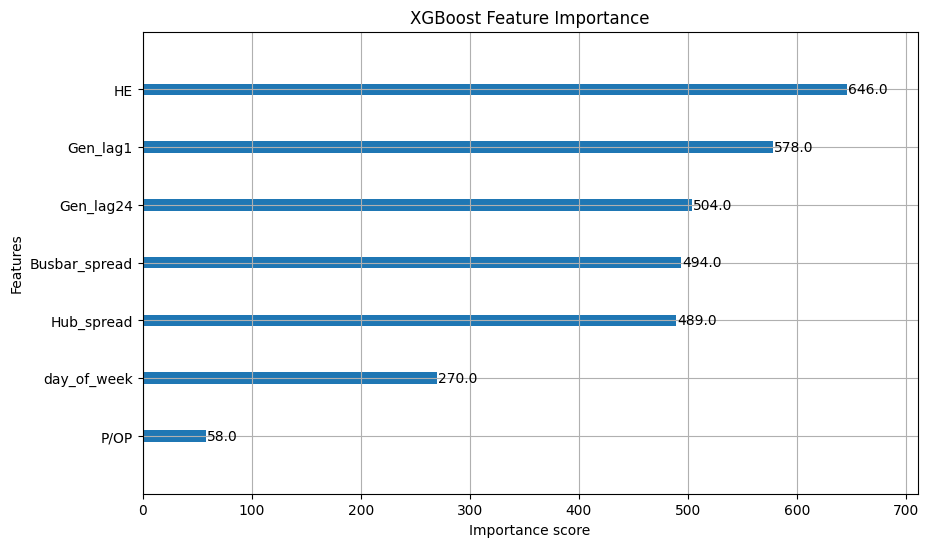

In [46]:
# plot feature importance
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10,6))
plot_importance(reg_xgb, ax=plt.gca())
plt.title("XGBoost Feature Importance")
plt.show()
